# Simple ARIMA model for non-seasonal time-serie forecast

Our goal in this challenge is to apply the basic concepts of time series analysis on one-dimension data

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults


import pmdarima as pm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
import itertools

import itertools
import pandas as pd
from sklearn.metrics import r2_score
import warnings

from matplotlib import pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
plt.style.use('fivethirtyeight')
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
from matplotlib.patches import Patch

##  1. Load Data and Plot Time Series
Let's start by loading the time series of the challenge and plot the time series

In [67]:
df = pd.read_csv('data/daily_restaurant_sales.csv')
df.head()

,x
0,88
1,84
2,85
3,85
4,84


In [68]:
df.describe()

,x
count,100.000000
mean,137.080000
std,39.999414
min,83.000000
25%,99.000000
50%,138.500000
75%,167.500000
max,228.000000


<Axes: >

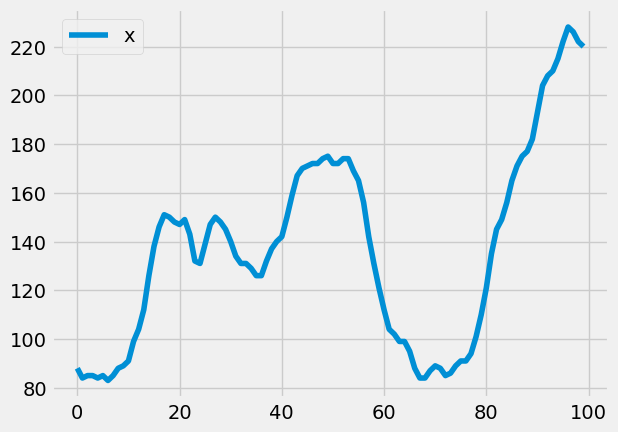

In [69]:
df.plot()

This abstract time serie does not seem seasonal, but with some increasing trend and somehow "sticky" (i.e. with some auto-regressivity). So it may be a good candidate for Auto-Regresive Moving Average (ARIMA) models


## 2. Build ARIMA model
We will try to forecast the data thanks to ARIMA models (Auto Regressive Integrated Moving Average).

For that, we will need to :
1. find how to stationarize the time serie (I in SARIMA)
2. find the auto-regressive (AR) part
3. find the Moving-Average (MA) part
4. Fit
5. Assess performance

### Step 1 - Ensure stationarity

ARIMA models applies to "stationary" time series only.

👉 Check its stationarity precisely using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html), and especially its p-value

In [70]:
adfuller(df.x)[1]

0.1244193544710952

The p-value should be  less than 0.05 to have a 95% confidence in the stationarity.  
If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

If the time series is not stationary, it needs to be stationarized through **differencing**. 
- It means that we take the difference between each value and the preceding one (*first difference*).
- Repeat process on the differentiated serie if you want the *second difference*, etc...

👉 Find the minimum order of differencing we need to make it stationnary (plot the curves to visualize them, and print their adfuller p-value to be sure)

<details>
    <summary>Hint</summary>

`pd.Series.diff`
</details>

In [71]:
df['diff_1']= df.x.diff()
df.head()

,x,diff_1
0,88,NaN
1,84,-4.0
2,85,1.0
3,85,0.0
4,84,-1.0


<Axes: >

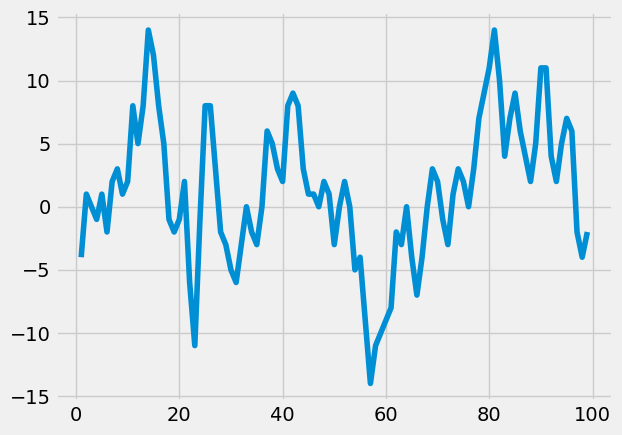

In [72]:
df['diff_1'].plot()

In [73]:
adfuller(df['diff_1'][1:])[1]

0.07026846015272707

We have a close-call here between one and two diff orders. Differentiating too much a time series may also reduce performance of your ARIMA models. Let's have a closer look:

👉 Plot autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) for diff order 1 and 2.

(💡Pro tip: Avoid duplicating statsmodels plots by calling `plt.show()` or by adding `;` to the end of each instantiation of a statsmodels plot)

In [74]:
df['diff_2']= df.x.diff().diff()
df.head()

,x,diff_1,diff_2
0,88,NaN,NaN
1,84,-4.0,NaN
2,85,1.0,5.0
3,85,0.0,-1.0
4,84,-1.0,-1.0


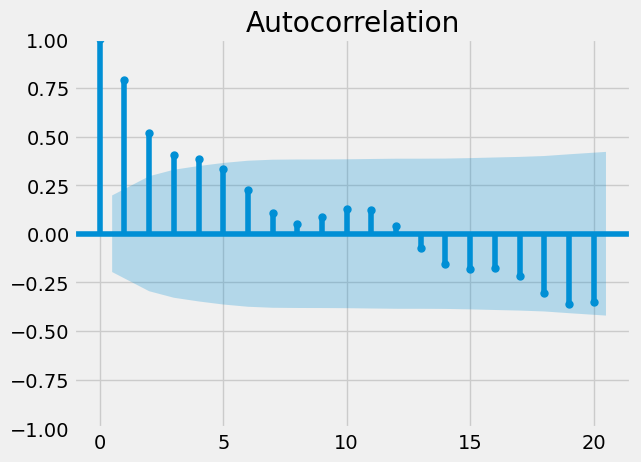

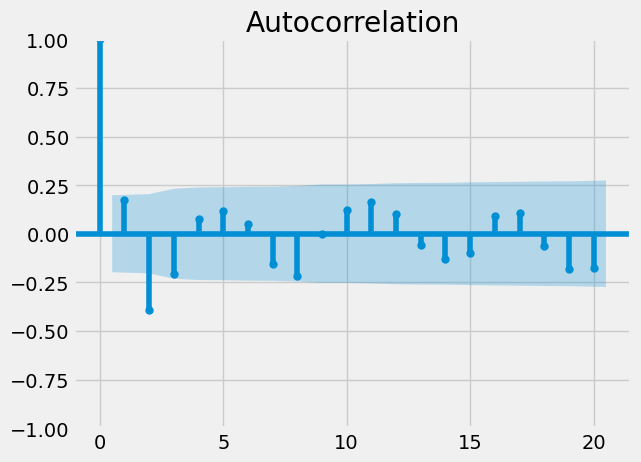

In [75]:
plot_acf(df['diff_1'][1:])
plot_acf(df['diff_2'][2:])
plt.show()

In our "second order diff" autocorrelation plot, the lag coefficient n°1 is close to 0, while the second one escapes far into negative territory. This might indicate we have over-differentiated the series. (Remember: we never care about the lag n°0 which is always equal to 1)

👉 Let's (temptatively) keep only one diff order and name this series `y_diff` (we can always try more diff later)

In [76]:
df['y_diff']= df.x.diff()
df.head()

,x,diff_1,diff_2,y_diff
0,88,NaN,NaN,NaN
1,84,-4.0,NaN,-4.0
2,85,1.0,5.0,1.0
3,85,0.0,-1.0,0.0
4,84,-1.0,-1.0,-1.0


We just found the term "I" in ARIMA: `d = 1` for 1-diff before stationary (I refers to "integration", "d" for differentiation...)


### Step 2 - Select AR order (p) and MA order (q)

#### MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d)}}$ cuts off

MA order (`q`) can be found by looking at the autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to`y_diff`. 

👉 determine `q`

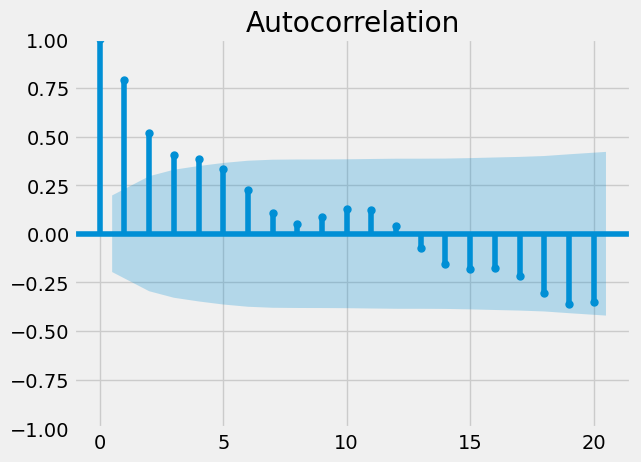

In [77]:
plot_acf(df['y_diff'][1:])
plt.show()

We could choose q = 4, but it's more conservatively to try with `q=2` to start with.

When in doubt, go with the simpler model that sufficiently explains the Y.

#### AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d)}}$  cuts off

AR order (`p`) can be found by investigating the **p**artial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to `y_diff`.

(Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series)

👉 Determine `p`

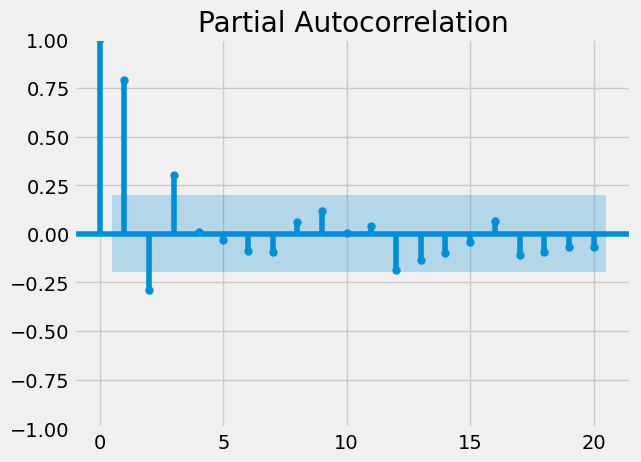

In [78]:
plot_pacf(df['y_diff'][1:],method='ywm')
plt.show()

We could choose `p = 3` as the first 3 lag terms seems above the significance level, but we could also go with a simpler model `p = 1`. 



### Step 3 - Build the model

Now that you have chosen the values for `p`, ` d` and `q` for the ARIMA, 

👉 build the `arima_model` from `statsmodels`.
- fit the the model
- print the model (`.summary`)

In [79]:
arima_model = ARIMA(df.x, order=(1, 1, 1))
result = arima_model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      x   No. Observations:                  100
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -254.150
Date:                Wed, 08 Mar 2023   AIC                            514.300
Time:                        16:51:04   BIC                            522.086
Sample:                             0   HQIC                           517.450
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6504      0.090      7.258      0.000       0.475       0.826
ma.L1          0.5256      0.088      5.994      0.000       0.354       0.697
sigma2         9.7934      1.405      6.970      0.000       7.040      12.547
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.12
Prob(Q):                              0.86   Prob(JB):                         0.94
Heteroskedasticity (H):               0.63   Skew:                            -0.08
Prob(H) (two-sided):                  0.19   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

☝️ If your p-values are too high, try remove these terms by reducing the corresponding AR or SA coefficients.

You can evaluate overall performance of your fit by minimizing the [`AIC - akaike information criterion`](https://towardsdatascience.com/the-akaike-information-criterion-c20c8fd832f2) value

It seems that the (1,1,1) ARIMA models have less chance of overfitting (p-values remains low) and maintain a quasi similar AIC score than other models

## 3. Evaluate model performance

👉 Visualize your model predictions with `.plot_predict()`

- Look closely at the method default params, especially `dynamic`. 
- Do you think your model would have such good performance in reality?

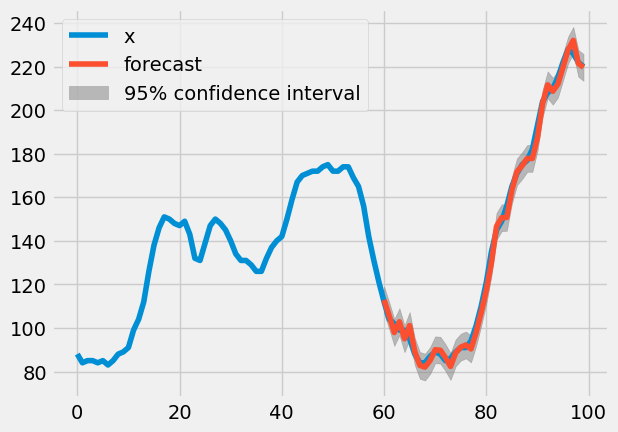

In [80]:
fig, ax = plt.subplots()
ax = df.x.plot(ax=ax)
plot_predict(result,df.index[60], ax=ax)
plt.show()

☝️ `dynamic=False` actually makes use of all available values `y` in order to predict `y_pred`, making your ARIMA prediction use up to $y_{t-1}$ to predict $y_t$. In reality, you don't have access to all `y`, especially if you want to predict several intervals in the future.

👉 Try to use `dynamic=True` to plot a prection of the _last 15 values_ in a situation where the model only have _access to data up to 85_. That is to say, the model:
- predicts 86 based on true [1...85]
- then predicts 87 based on [1...85] _plus_ it's previouly predicted value for 86
- etc...iteratively until 100

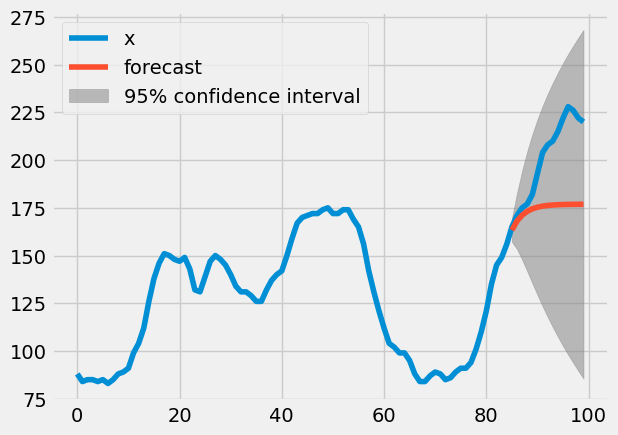

In [81]:
fig, ax = plt.subplots()
ax = df.x.plot(ax=ax)
plot_predict(result,df.index[85], ax=ax, dynamic=True)
plt.show()

☝️ That's still not a _true_ forecast!! Why??

<details>
    <summary>Answer</summary>

Our model has "seen" the whole `y_true` serie during the fitting phase!
</details>

### 3.1 Out-of-sample forecasts (real "future")

👉 Create a train-test-split keep the last 15 datapoints only for the test set, and train your ARIMA on the train set only.

In [82]:
train = df.x[0:85]
test = df.x[85:]

In [83]:
arima_model = ARIMA(train, order=(1, 1, 1))
result = arima_model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      x   No. Observations:                   85
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -217.055
Date:                Wed, 08 Mar 2023   AIC                            440.109
Time:                        16:51:04   BIC                            447.402
Sample:                             0   HQIC                           443.041
                                 - 85                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6597      0.097      6.790      0.000       0.469       0.850
ma.L1          0.4857      0.099      4.892      0.000       0.291       0.680
sigma2        10.1098      1.595      6.340      0.000       6.984      13.235
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.02
Prob(Q):                              0.85   Prob(JB):                         0.99
Heteroskedasticity (H):               0.64   Skew:                             0.03
Prob(H) (two-sided):                  0.25   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

👉 We are "now" in step 85 and have never seen the future:
- Use `.forecast()` method on your fitted model to "forecast" the 15 next datapoints (i.e beyond the end of your train dataset) 
- Plot forecasted values as well as the higher and lower range of 95% uncertainty interval

In [84]:
forecast = result.forecast(len(test), alpha=0.05)

In [85]:
forecast

85    163.161121
86    167.885191
87    171.001580
88    173.057410
89    174.413605
90    175.308265
91    175.898457
92    176.287796
93    176.544637
94    176.714070
95    176.825843
96    176.899577
97    176.948218
98    176.980306
99    177.001474
Name: predicted_mean, dtype: float64

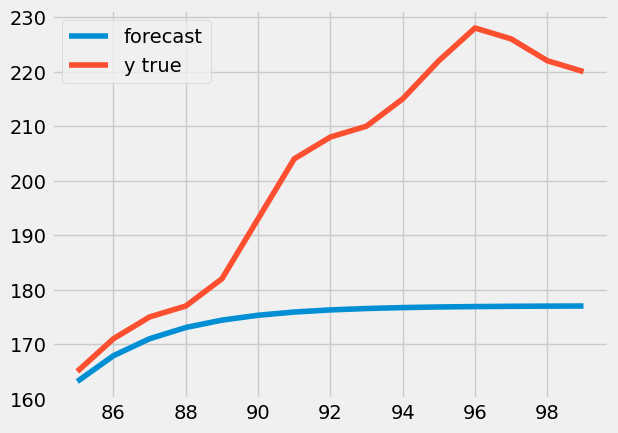

In [86]:
plt.plot(forecast, label='forecast')
plt.plot(test, label='y true')
plt.legend(loc='upper left')

👉 Try to also plot your previous 85 `y` real datapoints to better grasp model performance relative to the past

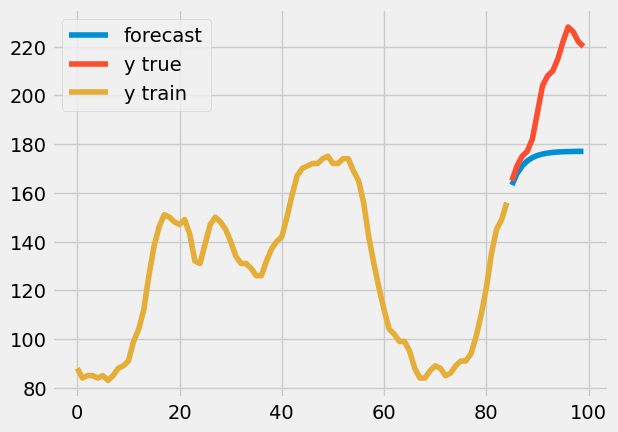

In [87]:
plt.plot(forecast, label='forecast')
plt.plot(test, label='y true')
plt.plot(train, label='y train')
plt.legend(loc='upper left')

In [88]:
fc = result.get_forecast(len(test.index)).summary_frame()
fc

x,mean,mean_se,mean_ci_lower,mean_ci_upper
85,163.161121,3.179587,156.929245,169.392997
86,167.885191,7.526027,153.134449,182.635933
87,171.001580,11.904618,147.668958,194.334203
88,173.057410,16.079401,141.542362,204.572457
89,174.413605,19.976692,135.260008,213.567203
90,175.308265,23.588483,129.075688,221.540842
91,175.898457,26.932996,123.110755,228.686158
92,176.287796,30.037461,117.415454,235.160138
93,176.544637,32.930495,112.002053,241.087220
94,176.714070,35.638866,106.863176,246.564965


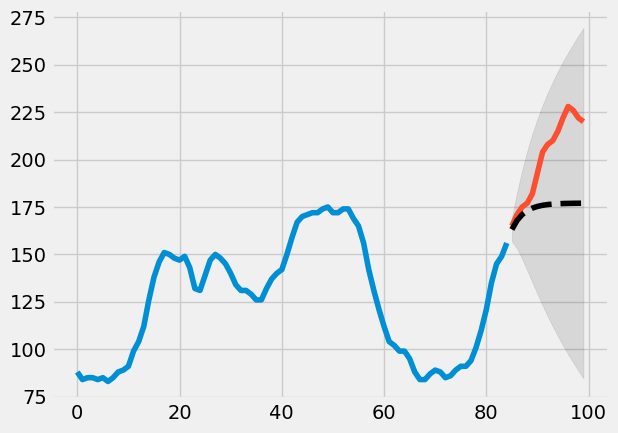

In [89]:
fig, ax = plt.subplots()

# Plot the data 
train.plot(ax=ax)
test.plot(ax=ax)

# Construct the forecasts
fc['mean'].plot(ax=ax, style='k--')
ax.fill_between(fc.index, fc['mean_ci_lower'], fc['mean_ci_upper'], color='k', alpha=0.1);

### 3.2 Can you trust your 95% confidence interval? (conditions for inference)

👉 Plot the residuals `model.resid` to ensure there are no patterns
- Normally distributed
- Mean zero
- Uniform variance
- No autoregressive patterns (you can plot_acf the residuals if you really want)

Note: residuals are constructed by 'seing' all data as in `plot_predict(dynamic=False)`

Also try to plot a histogram or kde fit of the residuals to see if they are approximately normally distributed.

<Axes: >

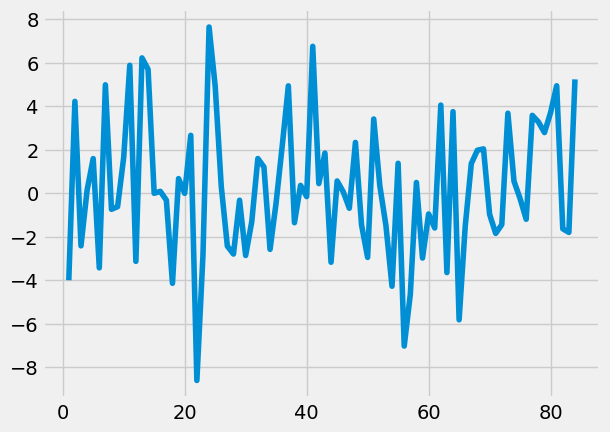

In [90]:
residuals = result.resid
residuals[1:].plot()

<Axes: >

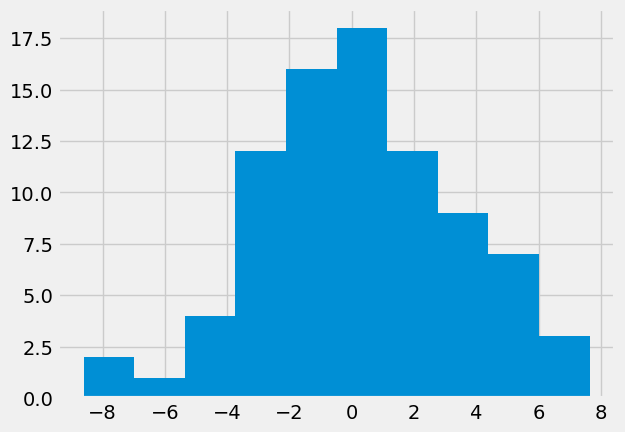

In [91]:
residuals[1:].hist()

## 3.3 Cross-validated performance metrics

👉 Below are the given the most common performance metrics for time series

In [92]:
def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:
    
    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true, fft=False)[1]                      # Lag 1 Autocorrelation of Error
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

👉 Play with you ARIMA hyper-parameters and see the impact on your forecast performance

In [93]:
arima_model = ARIMA(train, order=(1, 1, 1))
result = arima_model.fit()
forecast = result.forecast(len(test), alpha=0.05)
forecast_accuracy(y_pred= forecast, y_true= test)

{'mape': 0.12522187007497554,
 'me': -26.87149671358011,
 'mae': 26.87149671358011,
 'mpe': -0.12522187007497554,
 'rmse': 32.382383339972684,
 'acf1': 0.8714402830580923,
 'corr': 0.852851076651052,
 'minmax': 0.12522187007497554}

In [94]:
arima_model = ARIMA(train, order=(3, 1, 4))
result = arima_model.fit()
forecast = result.forecast(len(test), alpha=0.05)
forecast_accuracy(y_pred= forecast, y_true= test)

/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'mape': 0.15910595459137306,
 'me': -33.852592545436266,
 'mae': 33.852592545436266,
 'mpe': -0.15910595459137306,
 'rmse': 39.37803145011835,
 'acf1': 0.8556650245462283,
 'corr': 0.7707344627147583,
 'minmax': 0.159105954591373}

In [95]:
arima_model = ARIMA(train, order=(2, 1, 3))
result = arima_model.fit()
forecast = result.forecast(len(test), alpha=0.05)
forecast_accuracy(y_pred= forecast, y_true= test)

{'mape': 0.08048949436110808,
 'me': -17.312056946499577,
 'mae': 17.444152256571133,
 'mpe': -0.07974319317426315,
 'rmse': 21.972074746631716,
 'acf1': 0.8793450075911013,
 'corr': 0.9555111075593571,
 'minmax': 0.0804874173661062}

In [96]:
arima_model = ARIMA(train, order=(2, 1, 2))
result = arima_model.fit()
forecast = result.forecast(len(test), alpha=0.05)
forecast_accuracy(y_pred= forecast, y_true= test)

{'mape': 0.09867374794476512,
 'me': -21.251111340932432,
 'mae': 21.251111340932432,
 'mpe': -0.09867374794476512,
 'rmse': 26.04231961252857,
 'acf1': 0.8756630020707731,
 'corr': 0.9420678492263086,
 'minmax': 0.09867374794476502}

In [97]:
arima_model = ARIMA(train, order=(1, 1, 2))
result = arima_model.fit()
forecast = result.forecast(len(test), alpha=0.05)
forecast_accuracy(y_pred= forecast, y_true= test)

{'mape': 0.11663890389764896,
 'me': -25.04287896806761,
 'mae': 25.04287896806761,
 'mpe': -0.11663890389764896,
 'rmse': 30.264523561262582,
 'acf1': 0.8723950124180566,
 'corr': 0.9008321933902521,
 'minmax': 0.11663890389764886}

## 4 Grid Search
#link to understand Grid Search https://www.lovelyanalytics.com/2017/10/16/grid-search/

Try to run your own gridsearch for (p,d,q) using `pmdarima`. Use at least
- `trace=True`
- `error_action='ignore'`
- `suppress_warnings=True`

In [98]:
model = pm.auto_arima(train, 
                      start_p=0, start_q=0,
                      max_p=3, max_q=4, d=1,        
                      seasonal=False, trace=True, error_action='ignore',suppress_warnings=True, stepwizes=True)  

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=534.403, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=451.228, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=469.552, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=534.088, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=446.570, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=442.059, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=443.753, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=443.729, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=440.329, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=444.907, Time=0.01 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=442.026, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=442.052, Time=0.02 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 0.255 seconds


In [99]:
arima_model = ARIMA(train, order=(3, 1, 0))
result = arima_model.fit()
forecast = result.forecast(len(test), alpha=0.05)
forecast_accuracy(y_pred= forecast, y_true= test)

{'mape': 0.07090118242130689,
 'me': -15.068618208449227,
 'mae': 15.382626636945291,
 'mpe': -0.06912843458901406,
 'rmse': 19.501667685085476,
 'acf1': 0.8821550572626224,
 'corr': 0.9625590935865418,
 'minmax': 0.07089352608792887}

## Cross-validate performance of your model

In practice, Results and GridSearch should always be cross validated: 

Feel free to use [`sklearn.TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) to create continguous K-folds so as to truely evaluate the performance of your model and find the best hyper-params after cross validation

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0101.png'>

In [100]:
X = df.index
y = df.x

In [101]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits)

In [102]:
for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Fold: {fold}")
    print("TRAIN indices:", train_index, "\n", "TEST indices:", test_index)
    print("\n")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

Fold: 0
TRAIN indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] 
 TEST indices: [20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35]


Fold: 1
TRAIN indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35] 
 TEST indices: [36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51]


Fold: 2
TRAIN indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51] 
 TEST indices: [52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67]


Fold: 3
TRAIN indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67] 
 TEST indices: [68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83]


Fold: 4
TRAIN indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23

In [103]:
def plot_cv_indices(cv, n_splits, X, y, date_col = None):
    """Create a sample plot for indices of a cross-validation object."""
    
    fig, ax = plt.subplots(1, 1, figsize = (11, 7))
    
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=10, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)


    # Formatting
    yticklabels = list(range(n_splits))
    
    if date_col is not None:
        tick_locations  = ax.get_xticks()
        tick_dates = [" "] + date_col.iloc[list(tick_locations[1:-1])].astype(str).tolist() + [" "]

        tick_locations_str = [str(int(i)) for i in tick_locations]
        new_labels = ['\n\n'.join(x) for x in zip(list(tick_locations_str), tick_dates) ]
        ax.set_xticks(tick_locations)
        ax.set_xticklabels(new_labels)
    
    ax.set(yticks=np.arange(n_splits) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.2, -.2])
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)

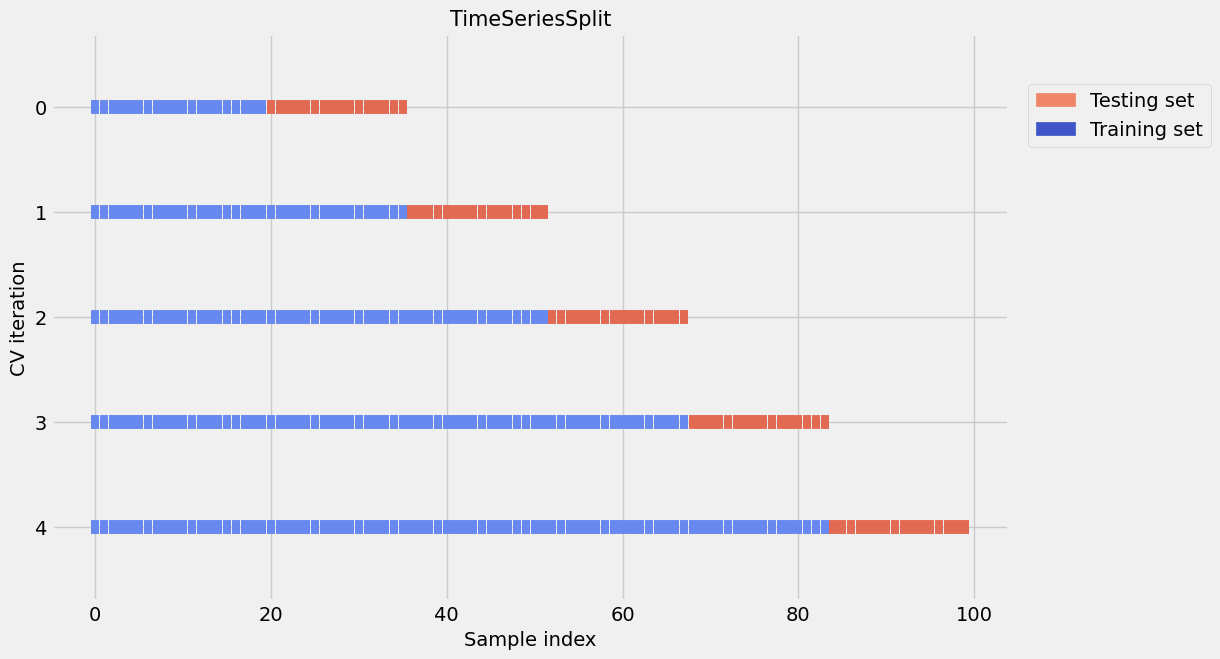

In [104]:
plot_cv_indices(tscv, n_splits, X, y)

In [105]:
for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    model = pm.auto_arima(X[train_index], 
                      start_p=0, start_q=0,
                      max_p=3, max_q=4,
                      d = 1,         
                      seasonal=False, trace=True, error_action='ignore',suppress_warnings=True) 
    print(f'kfold:{fold}, {model}')

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-381.075, Time=0.03 sec
Total fit time: 0.029 seconds
kfold:0,  ARIMA(0,1,0)(0,0,0)[0] intercept
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-725.631, Time=0.06 sec
Total fit time: 0.058 seconds
kfold:1,  ARIMA(0,1,0)(0,0,0)[0] intercept
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1058.519, Time=0.02 sec
Total fit time: 0.022 seconds
kfold:2,  ARIMA(0,1,0)(0,0,0)[0] intercept
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1407.042, Time=0.04 sec
Total fit time: 0.042 seconds
kfold:3,  ARIMA(0,1,0)(0,0,0)[0] intercept
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1772.220, Time=0.03 sec
Total fit time: 0.031 seconds
kfold:4,  ARIMA(0,1,0)(0,0,0)[0] intercept


In [107]:
range_p = [1,2]
range_d = [1]
range_q = [0,1,2]
grid = itertools.product(range_p, range_d, range_q)

orders = []
r2s = []
aics = []
fold_idxs = []

for (p,d,q) in grid:
    order = (p,d,q)
    folds = TimeSeriesSplit(n_splits=3)
    for fold_idx, (train_idx, test_idx) in enumerate(folds.split(X)):
        fold_idxs.append(fold_idx)
        y_train = y[train_idx]
        y_test = y[test_idx]
        
        try:
            model = ARIMA(y_train, order=order).fit()
            y_pred = model.forecast(len(y_test))
            y_true = y[test_idx]
            r2s.append(r2_score(y_pred, y_true))
            orders.append(order)
            aics.append(model.aic)
        except Exception as e:
            print(f"Error: {e}. Skipping this combination: {order}")
            continue

df = pd.DataFrame(list(zip(fold_idxs, orders, aics)),
                   columns =['Fold', '(p,d,q)', 'AIC'])

print(df.head())

/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


   Fold    (p,d,q)         AIC
0     0  (1, 1, 0)  138.206436
1     1  (1, 1, 0)  267.495981
2     2  (1, 1, 0)  396.239625
3     0  (1, 1, 1)  138.767756
4     1  (1, 1, 1)  259.998896


/opt/anaconda3/envs/time_series/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Je n'arrive pas à faire le gird search avec les cross validation.